# Qubit simulation jupyter notebook

### Author: Daniel Gonçalves Benvenutti - UNICAMP

This notebooks simulates the caracterization of a qubit with relaxation ($T_1$) and dephasing ($T_2$) colapse operators using the qutip quantum simulation library and the paralelism from qutip's library.

It has the following simulations:
- Rabi oscillation,
-  Rabi map,
- $T_1$ decay,
- Ramsey oscillation for $T_2^*$,
- Ramsey map,
- $T_2^{echo}$






In [2]:
# to use in google colab
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 18.9 MB/s eta 0:00:00


In [3]:
import qutip as qtp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# General parameters

Ref: [Naghiloo, Mahdi. "Introduction to experimental quantum measurement with superconducting qubits." arXiv preprint arXiv:1904.09291 (2019).](https://arxiv.org/pdf/1904.09291)

### Free evolution Hamiltonian
$$H=-0.5\omega_q \sigma_z$$

### Time dependant Hamiltonian with drive in the rotating frame
$$H=-0.5\omega_q \sigma_z-E_d(t) \sigma_x$$

### Collapse operators
$$\sqrt{\frac{1}{T_1}}\sigma_-, \sqrt{\frac{1}{2T_\varphi}}\sigma_z$$

### Measurement operator
$$n=\sigma_-^\dagger\sigma_-$$

In [57]:
#parameters
wq=5.0122e9 #qubit resonance frequency rad/s
Ed=0.6550e7 #driving energy rad/s

pi_pulse=np.pi/Ed

T1=17.3e-6 #relaxation time
T2=11e-6 #dephasing time

#(T2 must be T2<=2T1)
if T2>2*T1:
  raise Exception("T2 must be T2<=2T1")

#operators
sm=qtp.destroy(2)
sx=qtp.sigmax()
sz=qtp.sigmaz()
sy=qtp.sigmay()
n=sm.dag()*sm

#hamiltonian
def H(wq, Ed_t):
  #time independant hamiltonian
  if Ed_t==0:
    return -0.5*wq*sz
  #time dependant hamiltonian
  #[time independant part, [operator,time dependant operator amplitude]]
  #[qubit, [drive]]
  return [-0.5*wq*sz,[sx,Ed_t]]

#colapse operators
def c_ops(T1, T2):
  gamma_phi=1/T2-1/2/T1 #pure dephasing constant
  return [np.sqrt(1/T1)*sm,np.sqrt(gamma_phi/2)*sz]
  #return [np.sqrt(1/T1)*sm,np.sqrt(2*gamma_phi)*n] #same thing for dephasing but in different terms



# Rabi Oscillation



In [ ]:
#simulation
#initial state
psi0=qtp.basis(2,0)
t=np.linspace(0,5e-6,1000)
def rabi(Det):
  #Detuned rabi oscillation
  #drive angular freq
  wd=wq+Det
  #drive pulse
  def drive(t):
    return Ed*np.sin(wd*t)
  res=qtp.mesolve(H(wq,drive),psi0,t,c_ops(T1, T2),[n])
  #returns the whole oscillation for this detuning
  return res.expect[0]

In [ ]:

#runs simulation
res=rabi(0)

#rabi osc pi pulse
i=np.argmax(res)
print("pi pulse:", t[i])


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


pi pulse: 4.804804804804805e-07


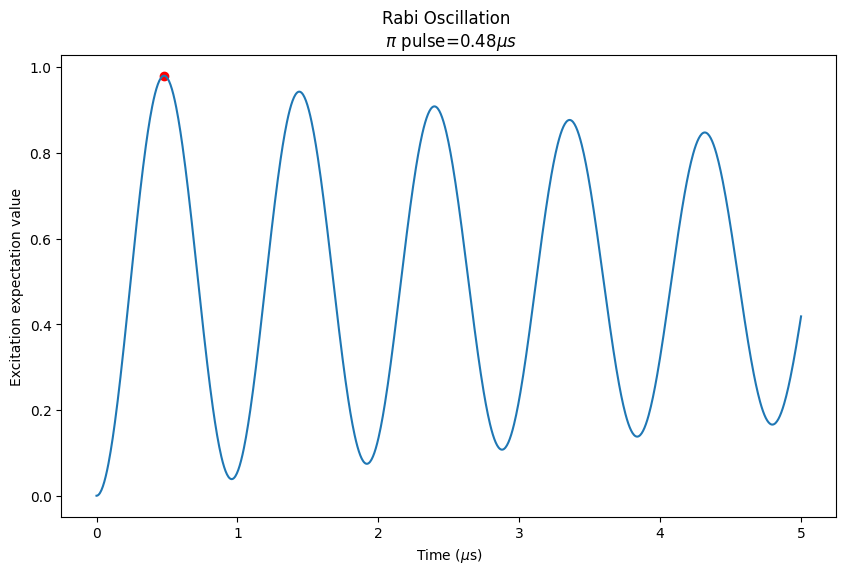

In [ ]:
# prompt: plot res

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.scatter(t[i]*1e6,res[i],color="red") #pi pulse peak
axes.plot(t*1e6, res)
axes.set_xlabel('Time ($\mu$s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'Rabi Oscillation \n $\pi$ pulse={pi_pulse*1e6:.2f}$\mu s$');


## Rabi map

In [ ]:
Det=np.linspace(-10e6,10e6,64)

#qutip's parallelism "map()" like function to evaluate all Detunings
chevron=list(qtp.parallel_map(rabi,Det,progress_bar=True))

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


10.9%. Run time:  15.85s. Est. time left: 00:00:02:09
20.3%. Run time:  26.64s. Est. time left: 00:00:01:44
31.2%. Run time:  36.84s. Est. time left: 00:00:01:21
40.6%. Run time:  46.06s. Est. time left: 00:00:01:07
50.0%. Run time:  53.55s. Est. time left: 00:00:00:53
60.9%. Run time:  64.61s. Est. time left: 00:00:00:41
70.3%. Run time:  73.07s. Est. time left: 00:00:00:30
81.2%. Run time:  82.31s. Est. time left: 00:00:00:18
90.6%. Run time:  91.37s. Est. time left: 00:00:00:09
100.0%. Run time:  98.65s. Est. time left: 00:00:00:00
Total run time:  98.67s


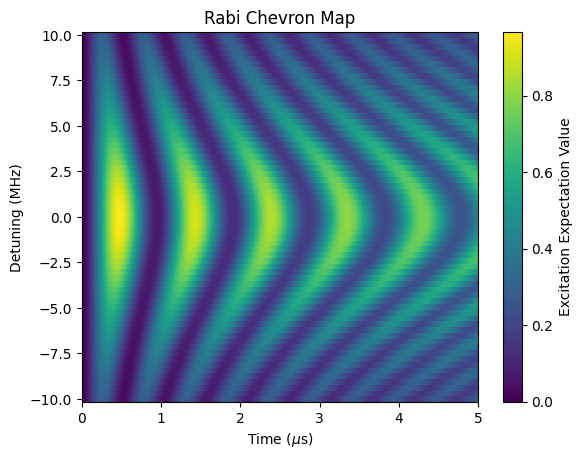

In [ ]:
# prompt: plot the rabi chevron map with t as x axis and Det as y axis in pcolor


# Assuming 't' and 'Det' are defined from the previous code
T, Det = np.meshgrid(t, Det)

plt.pcolor(T * 1e6, Det * 1e-6, np.array(chevron))  # Plotting with correct units
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Detuning (MHz)")
plt.title("Rabi Chevron Map")
plt.colorbar(label="Excitation Expectation Value")
plt.show()

# $T_1$ simulation

In [ ]:
#simulation

#initial state
psi0=qtp.basis(2,0)


#times
t_pi_vec=np.linspace(0,pi_pulse,100)# times for pi pulse simulation
t=np.linspace(0,100e-6,1000)
# you shouldn't start the free evolution at 0 because of the phase reference of the drive
#but since the drive in the T1 measurement is not used anymore after the pi pulse it's fine

#drive angular freq
wd=wq
#drive pulse
def drive(t):
  return Ed*np.sin(wd*t)

#pi pulse simulation with time dependant hamiltonian
#it just simulates an excitation drive and returns the final state in the res_exc
res_exc=qtp.mesolve(H(wq,drive),psi0,t_pi_vec,c_ops(T1,T2),[],options={"store_final_state":True})

#T1 free evolution decay with time independant hamiltonian for efficiency
res=qtp.mesolve(H(wq,0),res_exc.final_state,t,c_ops(T1,T2),[n])


/usr/local/lib/python3.10/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


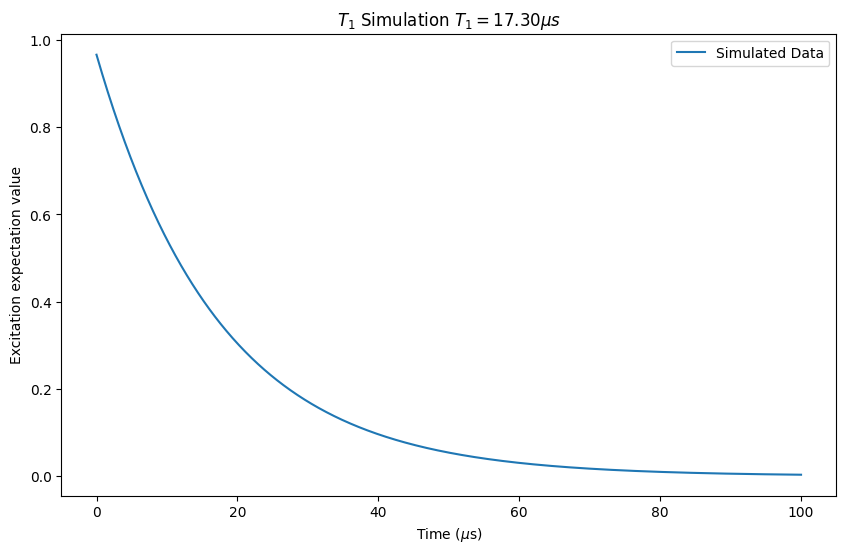

In [ ]:
# prompt: plot res as scatter and fit it with an exponential

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.plot(t*1e6, res.expect[0], label='Simulated Data')

axes.set_xlabel('Time ($\mu$s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'$T_1$ Simulation $T_1={T1*1e6:.2f}\mu s$')
axes.legend()
plt.show()



# $T_2$ Ramsey Simulation

In [8]:
#simulation

#initial state
psi0=qtp.basis(2,0)

#time values for the time dependant simulation during excitation
# The time dependant part of the simulation is usually a bottleneck
#less points doesn't necessarily means less time/work
pi_vec=np.linspace(0,pi_pulse/2,32)


def Ramsey(T, Det):
  #Ramsey simulation with interrogation time T and detuning Det

  #The ramsey osccillation is more inefficient to simulate than Rabi
  #Because you need to evolve the whole simulation for each interrogation time

  #drive pulse
  def drive(t):
    return Ed*np.sin((wq+Det*2*np.pi)*t)

  #Times for the free oscillation time independant simulation
  step=16e-9
  t=np.arange(0,T+step,step)

  #pi/2 pulse simulation with time dependant hamiltonian
  #it just simulates an excitation drive and returns the final state in the res_exc
  res=qtp.mesolve(H(wq,drive),psi0,pi_vec,c_ops(T1,T2),[],options={"store_final_state":True})

  #shift to keep the phase consistent
  shift=pi_vec[-1]

  #for T=0 or smaller than step not to throw an error
  if T>=step:
    #Ramsey free evolution simulation
    res=qtp.mesolve(H(wq,0),res.final_state,t+shift,c_ops(T1,T2),[],options={"store_final_state":True})
    shift+=t[-1]

  #second ramsey pulse
  res=qtp.mesolve(H(wq,drive),res.final_state,pi_vec+shift,c_ops(T1,T2),[],options={"store_final_state":True})

  #return excitation expected value of the final state like a measurement
  return qtp.expect(n,res.final_state)



In [9]:
# interrogation times
T=np.linspace(0,4e-6,64)

#wrapper to fix the detuning
def wrap_ramsey(T):
  return Ramsey(T,2e6)

#qutip's parallelism "map()" like function to evaluate all points in T using Ramsey
exp=list(qtp.parallel_map(wrap_ramsey,T,progress_bar=True))


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


10.9%. Run time:   1.41s. Est. time left: 00:00:00:11
20.3%. Run time:   3.55s. Est. time left: 00:00:00:13
31.2%. Run time:   5.56s. Est. time left: 00:00:00:12
40.6%. Run time:   7.29s. Est. time left: 00:00:00:10
50.0%. Run time:   9.27s. Est. time left: 00:00:00:09
60.9%. Run time:  11.99s. Est. time left: 00:00:00:07
70.3%. Run time:  14.51s. Est. time left: 00:00:00:06
81.2%. Run time:  18.86s. Est. time left: 00:00:00:04
90.6%. Run time:  22.17s. Est. time left: 00:00:00:02
100.0%. Run time:  25.91s. Est. time left: 00:00:00:00
Total run time:  25.93s


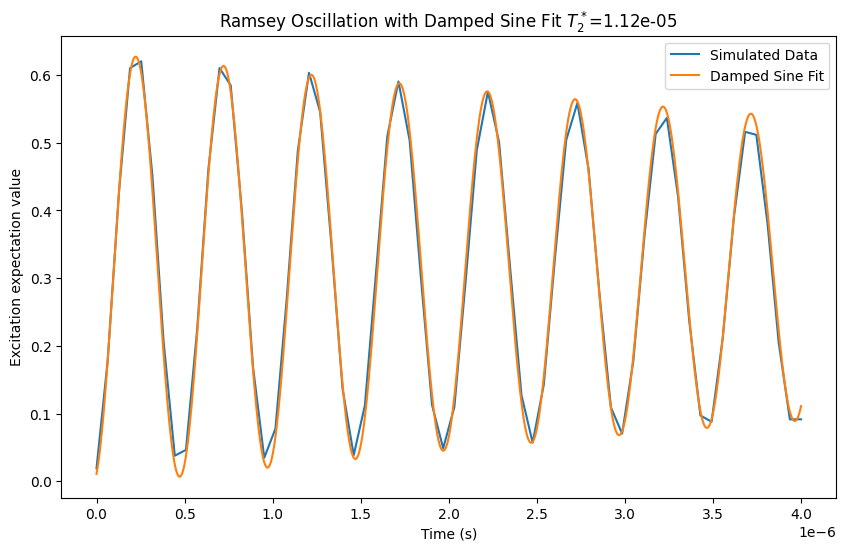

In [10]:
# prompt: plot exp and t as a ramsey oscillation with a damped sine fit


def damped_sine(t, amplitude, frequency, decay_constant, phase, offset):
  return amplitude * np.exp(-decay_constant * t) * np.sin(2 * np.pi * frequency * t + phase) + offset

params, covariance = curve_fit(damped_sine, T, exp, p0=[0.5, 1e6, 1e3, 0, 0.5])

amplitude, frequency, decay_constant, phase, offset = params
t=np.linspace(T[0],T[-1],len(T)*10)
fitted_exp = damped_sine(t, amplitude, frequency, decay_constant, phase, offset)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(T, exp, label='Simulated Data')
axes.plot(t, fitted_exp, label='Damped Sine Fit')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'Ramsey Oscillation with Damped Sine Fit $T_2^*$={1/params[2]:.2e}')
axes.legend()
plt.show()

## Ramsey map

In [ ]:
# interrogation times and detunings
T=np.linspace(0,4e-6,128)
Det=np.linspace(-2e6,2e6,72)

#generates pairs for each coordinate and puts them in a 1D list
T,Det=np.meshgrid(T,Det)
pairs=np.array([T.flatten(),Det.flatten()]).T

#wrapper to apply the pairs to the function input
def wrapper_ramsey(pair):
  return Ramsey(pair[0],pair[1])

#executes the simulations with parallelism
exp=list(qtp.parallel_map(wrapper_ramsey, pairs,progress_bar=True))

#reshapes the list of results into a matrix
rmap=np.array(exp).reshape(T.shape)

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


10.0%. Run time: 410.55s. Est. time left: 00:01:01:33
20.0%. Run time: 812.92s. Est. time left: 00:00:54:09
30.0%. Run time: 1179.17s. Est. time left: 00:00:45:51
40.0%. Run time: 1564.09s. Est. time left: 00:00:39:05
50.0%. Run time: 1952.46s. Est. time left: 00:00:32:32
60.0%. Run time: 2323.63s. Est. time left: 00:00:25:48
70.0%. Run time: 2697.43s. Est. time left: 00:00:19:15
80.0%. Run time: 3068.45s. Est. time left: 00:00:12:47
90.0%. Run time: 3459.49s. Est. time left: 00:00:06:24
100.0%. Run time: 3826.34s. Est. time left: 00:00:00:00
Total run time: 3826.39s


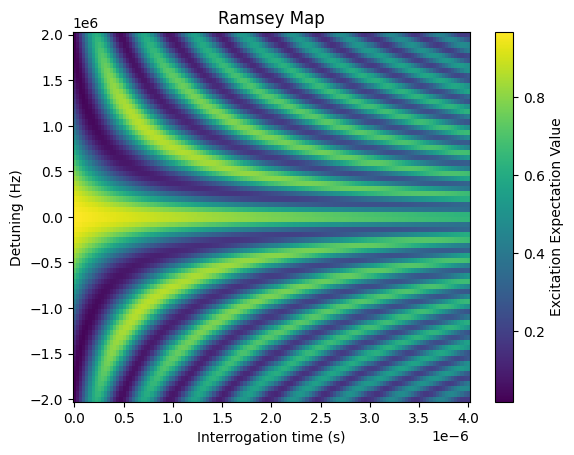

In [ ]:
# prompt: Plot exp pcolor map with T and Det as axis


# Assuming T and Det and exp are defined from the previous code block
plt.pcolormesh(T, Det, rmap)
plt.xlabel("Interrogation time (s)")
plt.ylabel("Detuning (Hz)")
plt.title("Ramsey Map")
plt.colorbar(label="Excitation Expectation Value")
plt.show()

# $T_2^{echo}$ simulation

## Não consigo fazer o t2echo ficar coerente com o T2 do operador de colapso. Ele sempre fica muito baixo



In [58]:
#simulation

#initial state
psi0=qtp.basis(2,0)

#time values for the time dependant simulation during excitation
# The time dependant part of the simulation is usually a bottleneck
pi2_vec=np.linspace(0,pi_pulse/2,128)
pi_vec=np.linspace(0,pi_pulse,256)


def echo(T, Det):
  #Ramsey simulation with interrogation time T and detuning Det

  #drive pulse
  def drive(t):
    return Ed*np.sin((wq+Det*2*np.pi)*t)

  #Times for the free oscillation time independant simulation
  step=2e-9
  t=np.arange(0,T+step,step)

  #pi/2 pulse simulation with time dependant hamiltonian
  #it just simulates an excitation drive and returns the final state in the res_exc
  res=qtp.mesolve(H(wq,drive),psi0,pi2_vec,c_ops(T1,T2),[],options={"store_final_state":True})

  #shift to keep the phase consistent
  shift=pi2_vec[-1]

  #for T=0 or smaller than step not to throw an error
  if T>=step:
    #t2echo first free evolution simulation
    res=qtp.mesolve(H(wq,0),res.final_state,t+shift,c_ops(T1,T2),[],options={"store_final_state":True})
    shift+=t[-1]


  #pi pulse simulation with time dependant hamiltonian
  res=qtp.mesolve(H(wq,drive),res.final_state,pi_vec+shift,c_ops(T1,T2),[],options={"store_final_state":True})
  shift+=pi_vec[-1]


  if T>=step:
    #t2echo second free evolution simulation
    res=qtp.mesolve(H(wq,0),res.final_state,t+shift,c_ops(T1,T2),[],options={"store_final_state":True})
    shift+=t[-1]

  #second pi/2 pulse
  res=qtp.mesolve(H(wq,drive),res.final_state,pi2_vec+shift,c_ops(T1,T2),[],options={"store_final_state":True})

  #return excitation expected value of the final state like a measurement
  return qtp.expect(n,res.final_state)



In [59]:
# the size of the two interrogation times in between pulses
T=np.linspace(0,25e-6,12)

#wrapper to fix the detuning
def wrap_echo(T):
  return echo(T,50)

#qutip's parallelism "map()" like function to evaluate all points in T using Ramsey
exp=list(qtp.parallel_map(wrap_echo,T,progress_bar=True))


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


16.7%. Run time:   1.76s. Est. time left: 00:00:00:08
25.0%. Run time:   3.26s. Est. time left: 00:00:00:09
33.3%. Run time:   5.65s. Est. time left: 00:00:00:11
41.7%. Run time:   9.28s. Est. time left: 00:00:00:12
50.0%. Run time:  12.98s. Est. time left: 00:00:00:12
66.7%. Run time:  21.78s. Est. time left: 00:00:00:10
75.0%. Run time:  26.13s. Est. time left: 00:00:00:08
83.3%. Run time:  31.76s. Est. time left: 00:00:00:06
91.7%. Run time:  38.28s. Est. time left: 00:00:00:03
100.0%. Run time:  41.94s. Est. time left: 00:00:00:00
Total run time:  41.97s


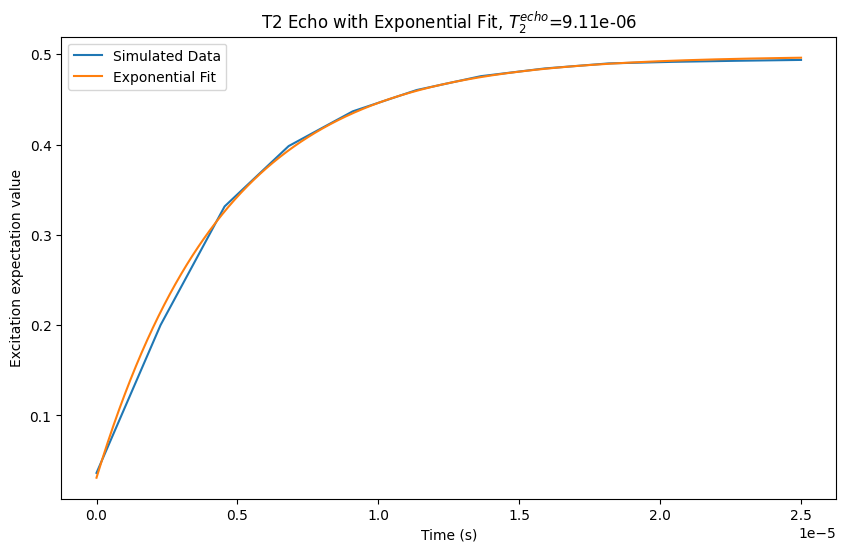

In [60]:
# prompt: plot the t2 echo exp with T and an exponential upside down non oscillating fit with the time constant in the title of the graph

# Assuming T and exp are defined from the previous code block (T2 echo simulation)

def exponential_decay(t, amplitude, decay_constant, offset):
    return amplitude * np.exp(-t / decay_constant) + offset

params, covariance = curve_fit(exponential_decay, T, exp, p0=[-1, 11e-6, 0.5])

amplitude, decay_constant, offset = params
t_fit = np.linspace(T[0], T[-1], 1000)
fitted_exp = exponential_decay(t_fit, amplitude, decay_constant, offset)


fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(T, exp, label='Simulated Data')
axes.plot(t_fit, fitted_exp, label='Exponential Fit')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'T2 Echo with Exponential Fit, $T_2^{{echo}}$={2*decay_constant:.2e}')
axes.legend()
plt.show()